# Deep Learning Project

## Final report

## Study of the impact on the ratio of unlabeled to labeled data on top-1 accuracy on the CIFAR-10 dataset and House Numbers dataset

Pierre Andurand (pa2570)
Tzu Yi Chuang (tc3075)
Kuan Yu Ko (kk3376)

We hereby investigate the role of the unlabeled to labeled data ratio on the accuracy of the Self Training Noised Student Model (STNS). This is the latest state-of-the-art semi supervised computer vision algorithm which is claimed to improve ImageNet classification. 
We test STNS on 2 separate algorithms: a relatively simple convolutional neural network (Simple Model), and a more complex one: Resnet20. 2 datasets are tried out: House Numbers, and CIFAR10.
For the Student Model, we add a Dropout(0.5) layer as the penultimate layer. We also investigate the effect of adding extra noise to the Student Model by running data augmentation on the images. So we will do tests with data augmentation (DA), and without data augmentation (NDA).
We assess different types of tests. With Test1, we investigate if we could increase the accuracy of the fully supervised algorithm on the full dataset with the help of STNS. We first run the fully supervised algorithm on the labeled dataset. We then run STNS with different ratios and investigate its impact on accuracy on test data.
For Test2, we take a balanced sample of 5000 images which becomes our labelled dataset. We run the fully supervised algorithm on it. We then run STNS using a part of the remaining dataset which we use as unlabeled. The size of the unlabeled dataset used is controlled by the chosen ratio of unlabeled/labeled data. We investigate is there is an optimal ratio to use for semi supervised learning, or if it is too dependent of the underlying algorithm used and the datasets and other parameters.
The fully supervised algorithm is trained for 100 epochs, a level of epochs above which there is very little improvement.
We do 10 loops of Student-Teacher in STNS, which each loop having 10 epochs. We use the Adam optimizer, and a learning rate of lr=0.0001 for the Student. 
For Test 1 we do 6 loops of Teacher-Student as it is very time consumming. We use soft labels rather than hard labels as it helps the accuracy.

In [1]:
# Resnet for CIFAR10 taken from Keras https://keras.io/examples/cifar10_resnet/



import matplotlib.pyplot as plt
import tensorflow as tf
# limit GPU memory to stop kernel crash
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # select GPU
    tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
layers = tf.keras.layers
import numpy as np
print(tf.__version__)
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.layers import Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
import os


def prepare_cifar10_data(subtract_pixel_mean = True):
    
    # The data, split between train and test sets:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # Normalize data.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    num_classes=10
    # If subtract pixel mean is enabled (Subtracting pixel mean improves accuracy)
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
        
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return (x_train, y_train),(x_test,y_test) 
    

    
def prepare_house_numbers_data(subtract_pixel_mean = True):
    ## We import housenumber dataset from http://ufldl.stanford.edu/housenumbers/

    #Loading dataset
    num_classes=10
    from scipy.io import loadmat

    train = loadmat('train_32x32.mat')
    test = loadmat('test_32x32.mat')

    # train and test are python dictionaries
    # keys are ['__header__', '__version__', '__globals__', 'X', 'y']

    x_train = train['X']
    y_train = train['y']
    x_test = test['X']
    y_test = test['y']

    # x and y are numpy ndarrays

    print("Shape of x_train is:", x_train.shape)
    print("Shape of y_train is:", y_train.shape)
    print("Shape of x_test is:", x_test.shape)
    print("Shape of y_test is:", y_test.shape)

    x_train = x_train[:,:,:,:]
    x_test = x_test[:,:,:,:]

    x_train = np.rollaxis(x_train, 3)
    x_test = np.rollaxis(x_test, 3)

    print("Shape of x_train is now:", x_train.shape)
    print("Shape of x_test is now:", x_test.shape)

    y_train = y_train[:,0]
    y_test = y_test[:,0]

    print("Shape of y_train is now:", y_train.shape)
    print("Shape of y_test is now:", y_test.shape)

    y_train[y_train==10] = 0
    y_test[y_test==10] = 0

    print("labels of y_train are", np.unique(y_train[:]))
    print("labels of y_test are", np.unique(y_test[:]))
    
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # If subtract pixel mean is enabled (Subtracting pixel mean improves accuracy)
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
        
    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    return (x_train, y_train),(x_test,y_test) 
    

#Defining Resnet20 model




# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------






def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




def choose_resnet_model(input_shape, n=3, version=1):
    
    # Model version
    # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)

    # Computed depth from supplied model parameter n
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)


    # Input image dimensions.
    #input_shape = x_train.shape[1:]

    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])

    init = model.get_weights()

    return model, init, model_type



def choose_simple_teacher_model(input_shape, num_classes=10):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])

    init = model.get_weights()

    return model, init


    

def train_model(init, model, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, epochs=100, 
                model_name= 'keras_cifar10_trained_teacher.h5'):
    
    # Prepare model model saving directory.
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    
    model.set_weights(init)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])
    
    # This will do preprocessing and realtime data augmentation:
    print("Using real-time data augmentation.")
    datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

    datagen.fit(x_train)

    # Fit the noised student model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            epochs=epochs, verbose=1, workers=4,validation_data=(x_test,y_test))

    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Supervised learning model with '+str(epochs)+'epochs \n')
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

    
    # Save model and weights
    model.save(filepath)
    print('Saved trained model at %s ' % filepath)

    return scores[1], filepath






8 Physical GPUs, 1 Logical GPUs
2.1.0


Using TensorFlow backend.


 
# Test 1
Below we would like to check if starting from the weights of the fully supervised model trained above, we would get an increase in accuracy if we run STNS on the full dataset with different ratios of unlabeled to labeled data. And if the accuracy goes up, we would like to see what is the optimal ratio. 
The STNS algorithm used is as follows:
We do a loop over different ratios of label to unlabelled data (rate). And each loop does the following:
1) take the weights from the fully supervised teacher model trained in box above 
2) X cycles of: un-noised model (teacher)->predict hard pseudolabel->training 10 epochs for noised model (student=teacher+dropout noise) on labeled+pseudo labeled->new weights. 
X is what is called loop in the code.
The student model will be the teacher model noised by a Dropout(0.5) before the last layer. And we can also use data augmentation to add to the noise for the student model

In [2]:
#Defining noised Student with a Dropout(0.5) just before the output layer


def noised_resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    y = Dropout(0.5)(y)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def noised_resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    y = Dropout(0.5)(y)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def choose_noised_resnet_model(input_shape, n=3, version=1):

    # Model version
    # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)

    # Computed depth from supplied model parameter n
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)
    if version == 2:
        model = noised_resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = noised_resnet_v1(input_shape=input_shape, depth=depth)

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])
    
    print(model_type)
    
    return model 




def choose_simple_student_model(input_shape, num_classes=10, lr=0.0001):
    #Model we used in the Milestone. Much quicker to run than Resnet. To be used to do quick tests.
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr),
                  metrics=['accuracy'])


    return model










In [12]:
def stns_full_dataset(x_train,y_train,x_test,y_test,rate,teacher, student,teacher_path,accuracy_supervised, data_augmentation, 
                      loops=6, lr=0.0001, hard_labels=False):
    
    # lr is the learning rate for the student only
    
    num_classes=10

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
                # set input mean to 0 over the dataset
                featurewise_center=False,
                # set each sample mean to 0
                samplewise_center=False,
                # divide inputs by std of dataset
                featurewise_std_normalization=False,
                # divide each input by its std
                samplewise_std_normalization=False,
                # apply ZCA whitening
                zca_whitening=False,
                # epsilon for ZCA whitening
                zca_epsilon=1e-06,
                # randomly rotate images in the range (deg 0 to 180)
                rotation_range=0,
                # randomly shift images horizontally
                width_shift_range=0.1,
                # randomly shift images vertically
                height_shift_range=0.1,
                # set range for random shear
                shear_range=0.,
                # set range for random zoom
                zoom_range=0.,
                # set range for random channel shifts
                channel_shift_range=0.,
                # set mode for filling points outside the input boundaries
                fill_mode='nearest',
                # value used for fill_mode = "constant"
                cval=0.,
                # randomly flip images
                horizontal_flip=True,
                # randomly flip images
                vertical_flip=False,
                # set rescaling factor (applied before any other transformation)
                rescale=None,
                # set function that will be applied on each input
                preprocessing_function=None,
                # image data format, either "channels_first" or "channels_last"
                data_format=None,
                # fraction of images reserved for validation (strictly between 0 and 1)
                validation_split=0.0)
    
    
    # rate= n_pseudo/n_true, unlabeled to labeled ratio
    
    n_total=x_train.shape[0]

    # total number of train images (n_total) = number of true label images (n_true) + number of pseudo label images (n_pseudo)
    #                                        = n_pseudo(1/rate+1)
    # n_pseudo = n_total/(1/rate+1); n_true=n_total-n_pseudo

    #loop over rate values in order to find the optimal rate value for the self-learning semi supervised learning, 
    #ie one that will maximize accuracy
    j=0
    accuracy=np.zeros(rate.shape[0])
    for r in rate:
    
        print("rate="+str(r)+":\n")
        n_pseudo=n_total/(1+(1/r))
        n_true=n_total-n_pseudo
        mask_true=np.random.choice(int(n_total),int(n_true),replace=False) #generating n_true integers between 0 and n_total-1
        mask_pseudo=[item for item in range(n_total) if item not in mask_true] #all the other numbers between 0 and n_total-1 which are not in mask_true
        mask_pseudo=np.array(mask_pseudo)
        x_true=x_train[mask_true[:]] #x for the labeled data
        y_true=y_train[mask_true[:]] #y for the labeled data
        x_pseudo=x_train[mask_pseudo[:]] #x for the unlabeled data (pseudo)
        #Taking weights from supervised model on full data (box above) 
        teacher.load_weights(teacher_path)
        teacher.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=lr_schedule(0)),
                  metrics=['accuracy'])
        #evaluating teacher model on test data    
        scores=teacher.evaluate(x_test,y_test,verbose=0)
        print("Original model with labelled data only predicting on test data: ",scores[1])

        x_true_pseudo=np.concatenate([x_true,x_pseudo]) #concatenating x for labeled and unlabeled data
        print('x_true_pseudo.shape: ',x_true_pseudo.shape)
        
        
        y_pseudo=teacher.predict(x_pseudo) #predicting labels on unlabeled data
        
        if hard_labels==True:
            y_pseudo = y_pseudo.argmax(axis=-1) 
            y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes) 
        
        
        y_true_pseudo=np.concatenate([y_true,y_pseudo]) #concatenating y for labeled and pseudo labeled
        print('y_true_pseudo.shape: ', y_true_pseudo.shape)
        student.load_weights(teacher_path)
        for i in range(loops): 
            # loops of 10 epochs of noised student training for labeled and pseudo labeled data (step 3 in article)
            # followed by generating predictions on unlabeled data with the teacher model (=un-noised student)
            # which uses the weights of the trained noised student (noise does not change the weights structure of models) (step 2 in article)

            student.compile(loss='categorical_crossentropy',
                              optimizer=Adam(learning_rate=lr),
                              metrics=['accuracy'])
          

            # Fit the noised student model 
            if data_augmentation==False:
                training=student.fit(x_true_pseudo, y_true_pseudo, batch_size=32,
                                epochs=5, verbose=1, workers=4)
            else:
                datagen.fit(x_true_pseudo)
                training=student.fit_generator(datagen.flow(x_true_pseudo, y_true_pseudo, batch_size=32),
                                epochs=5, verbose=1, workers=4)

            # Save weights
            weights=student.get_weights()
            # Load weights for teacher model (un-noised)
            teacher.set_weights(weights)
            
            y_pseudo=teacher.predict(x_pseudo)
            
            if hard_labels==True:
                y_pseudo = y_pseudo.argmax(axis=-1) 
                y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes) 
            
            scores=teacher.evaluate(x_test,y_test,verbose=0) #evaluating model on test data
            print('iteration: ',i)
            print('Test loss:', scores[0])
            print('Test accuracy:', scores[1])

            y_true_pseudo=np.concatenate([y_true,y_pseudo]) #new y_true_pseudo to be used in next loop
            
        accuracy[j]=scores[1]
        j+=1

    supervised=[accuracy_supervised for i in range(len(rate))]
    plt.plot(rate,accuracy)
    plt.plot(rate,supervised,'r')
    plt.xlabel('Rate')
    plt.ylabel('Accuracy top 1')
    if data_augmentation==False:
        plt.title('Test1 - Accuracy as a function of rate - No data augmentation')
    else:
        plt.title('Test1 - Accuracy as a function of rate - with data augmentation')
    plt.show()
    
    return accuracy

# Test 2
Now, we take a subset of 5,000 pictures that we use as labeled, and use part of the rest of the dataset as unlabeled. We run the teacher model on that labeled dataset. And then run STNS. We do that for different rate levels, and compare accuracies.
We investigate different number of Student loops (variable: loops), different learning rates for the Student model (lr=0.0001 and 0.001), and if we add data augmentation to the student or not (DA vs NDA).


In [14]:
# Varying the ratio for 5000 labeled images. Rest of training dataset unlabeled with ratio determining size of total dataset.
# Testing on full test dataset



def prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size=5000, num_classes=10):
    #Creating a balanced dataset of 5000 images (500 per class)
    total_size_cifar10=x_train.shape[0]   
    print(total_size_cifar10)
    print(y_train.shape)
    y_train=y_train.argmax(axis=-1)
    print(y_train.shape)
    #checking that classes are balanced
    for i in range(num_classes):
        print(str(i)+":",sum(y_train==i))

    #Selecting 500 images of each class
    k=0
    x_true=np.zeros((sample_size,32,32,3))
    y_true=np.full((sample_size,),-1)
    mask2=[]
    for i in range(total_size_cifar10):
        #print(i)
        for j in range(num_classes):
            if sum(y_true==j)<sample_size/num_classes:
                if y_train[i]==j:
                    x_true[k,:]=x_train[i,:]
                    y_true[k]=y_train[i]
                    k+=1
                    mask2.append(i)
                    break
        #print('k=',k)
        if k==sample_size:
            break
        
    #print(y_small_train[0:40])
    print(x_true.shape)
    print(y_true.shape)


    #verifying that there are 500 images in each class
    for i in range(num_classes):
        print(str(i)+":",sum(y_true==i))
    
    y_true=keras.utils.to_categorical(y_true, 10)
    
    return x_true, y_true, mask2
 
def stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher, student, sample_size=5000, epochs=100, 
              data_augmentation=True, lr=0.0001, loops=10, hard_labels=False):
    
    #data_augmentation is if we add noise to the data entered to the student
    # lr is the learning rate for the student only
    
    total_size_cifar10=x_train.shape[0]
    num_classes=10
    x_true, y_true, mask2 = prepare_smaller_labeled_training_dataset(x_train, y_train, sample_size, num_classes=num_classes)
    
    accuracy2_supervised, teacher2_path = train_model(init, teacher, x_true, y_true, x_test, y_test, batch_size=32, 
                                                      num_classes=num_classes, epochs=epochs, 
                                                       model_name= model_name)

    print('Small sample of 5000 training images, Supervised learning model with '+str(epochs)+'epochs \n')
    print('Test accuracy:', accuracy2_supervised)
    
    
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)
    
    
    
    
    
    mask3=[i for i in range(total_size_cifar10) if i not in mask2]
    x_total_unlabeled=x_train[mask3,:]
    print("size x_total_unlabeled (should be 45,000): ", x_total_unlabeled.shape[0])
    
    # rate= n_pseudo/n_true, n_true=sample_size

    number_rate=len(rate)
    
    #n_total=sample_size*(1+rate)

    # total number of train images (n_total) = number of true label images (sample_size) + number of pseudo label images (n_pseudo)
    #                                        = sample_size(rate+1)
    # n_pseudo = sample_size*rate

    #loop over rate values in order to find the optimal rate value for the self-learning semi supervised learning, 
    #ie one that will maximize accuracy
    
    accuracy2=np.zeros(number_rate)
    j=0
    for r in rate:
    
        teacher.load_weights(teacher2_path)
        student.load_weights(teacher2_path)
    
        print("rate="+str(r)+":\n")
        n_pseudo=int(sample_size*r)
        n_true=sample_size
        n_total=n_true+n_pseudo
        print("n_total, n_true, n_pseudo: ", n_total, n_true, n_pseudo)
        x_pseudo=x_total_unlabeled[0:n_pseudo,:] #x for the unlabeled data (pseudo)
        x_true_pseudo=np.concatenate([x_true,x_pseudo]) #concatenating x for labeled and unlabeled data
        print('x_true_pseudo.shape: ',x_true_pseudo.shape)
        y_pseudo=teacher.predict(x_pseudo) #predicting labels on unlabeled data
        
        if hard_labels==True:
            y_pseudo = y_pseudo.argmax(axis=-1) 
            y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes) 
        
        y_true_pseudo=np.concatenate([y_true,y_pseudo]) #concatenating y for labeled and pseudo labeled
        
        #print('y_true_pseudo.shape: ', y_true_pseudo.shape)
        
        for i in range(loops): 
            # Loops of 10 epochs of noised student training for labeled and pseudo labeled data (step 3 in article)
            # followed by generating predictions on unlabeled data with the teacher model (=un-noised student)
            # which uses the weights of the trained noised student (noise does not change the weights structure of models) (step 2 in article)
            print(i)
            student.compile(loss='categorical_crossentropy',
                              optimizer=Adam(learning_rate=0.0001),
                              metrics=['accuracy'])
            
            # Fit the noised student model 
            if data_augmentation==False:
                training=student.fit(x_true_pseudo, y_true_pseudo, batch_size=32,
                                epochs=5, verbose=1, workers=4)
            else:
                datagen.fit(x_true_pseudo)
                training=student.fit_generator(datagen.flow(x_true_pseudo, y_true_pseudo, batch_size=32),
                                epochs=5, verbose=1, workers=4)
            
            # Save weights
            weights=student.get_weights()
            # Load weights for teacher model (un-noised)
            teacher.set_weights(weights)
            y_pseudo=teacher.predict(x_pseudo) #predicting labels on unlabeled data
            
            if hard_labels==True:
                y_pseudo = y_pseudo.argmax(axis=-1) 
                y_pseudo=keras.utils.to_categorical(y_pseudo, num_classes)
            
            scores3=teacher.evaluate(x_test,y_test,verbose=0) #evaluating model on test data
            print('iteration: ',i)
            print('Test loss:', scores3[0])
            print('Test accuracy:', scores3[1])
            y_true_pseudo=np.concatenate([y_true,y_pseudo]) #new y_true_pseudo to be used in next loop
    
        accuracy2[j]=scores3[1]
        j+=1

    supervised2=[accuracy2_supervised for i in range(number_rate)]
    plt.plot(rate, accuracy2)
    plt.plot(rate, supervised2,'r')
    plt.xlabel('Rate')
    plt.ylabel('Accuracy top 1')
    if data_augmentation==False:
        plt.title('Test2 - Accuracy as a function of rate - No data augmentation')
    else:
        plt.title('Test2 - Accuracy as a function of rate - with data augmentation')
    plt.show()
    
    return accuracy2
    
    


# Running tests below
As we ran different notebooks on different GPUs, here we run very light versions (low loops, and low epochs) to show that the code works. The results are in a separate file and were hardcoded, copying the results of each GPU

Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
50000
(50000, 10)
(50000,)
0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
157/157 [==============================] - 17s 108ms/step - loss: 2.0712 - accuracy: 0.3066 - val_loss: 2.6846 - val_accuracy: 0.2408
Epoch 2/10
157/157 [==============================] - 8s 53ms/step - loss: 1.7419 - accuracy: 0.4160 - val_loss: 2.0111 - val_accuracy: 0.3440
Epoch 3/10
157/157 [==============================] - 8s 50ms/step - loss: 1.6234 - accuracy: 0.4616 - val_loss: 1.8487 - val_accuracy: 0.4154
Epoch 4/10
157/157 [==============================] - 8s 51ms/step - loss: 1.5452 - accuracy: 0.4978 - val_loss: 2.0146 - val_accuracy: 0.4073
Epoch 5/10
157/157 [==============================] - 8s 53ms/step - loss: 1.4759 - accuracy: 0.5286 - val_loss

0
Epoch 1/10
547/547 [==============================] - 23s 41ms/step - loss: 2.1354 - accuracy: 0.4754
Epoch 2/10
547/547 [==============================] - 17s 30ms/step - loss: 1.7885 - accuracy: 0.5299
Epoch 3/10
547/547 [==============================] - 17s 31ms/step - loss: 1.6791 - accuracy: 0.5559
Epoch 4/10
547/547 [==============================] - 17s 31ms/step - loss: 1.6235 - accuracy: 0.5717
Epoch 5/10
547/547 [==============================] - 17s 30ms/step - loss: 1.5874 - accuracy: 0.5875
Epoch 6/10
547/547 [==============================] - 17s 30ms/step - loss: 1.5597 - accuracy: 0.5996
Epoch 7/10
547/547 [==============================] - 18s 33ms/step - loss: 1.5457 - accuracy: 0.6086
Epoch 8/10
547/547 [==============================] - 17s 32ms/step - loss: 1.5203 - accuracy: 0.6113
Epoch 9/10
547/547 [==============================] - 17s 31ms/step - loss: 1.5008 - accuracy: 0.6221
Epoch 10/10
547/547 [==============================] - 17s 32ms/step - loss: 1.4

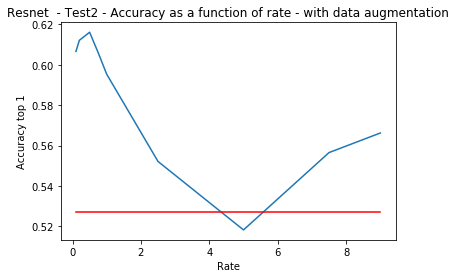

In [6]:
#### Run all the definitions above, and then run the calculations in following cells

#Running Test2 for CIFAR10 DA with Resnet
#For a proper test input epochs=100, and loops=10
epochs=10
loops=1

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3, version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3, version=1)
rate=np.array([0.1,0.2,0.5,0.75,1,2.5,5, 7.5, 9])
model_name= 'Resnet_cifar10_trained_teacher_5000_da.h5'
accuracy = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher,
                      student, sample_size=5000, epochs=epochs, 
                      data_augmentation=True, lr=0.0001, loops=loops, hard_labels=False)

Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
50000
(50000, 10)
(50000,)
0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
157/157 [==============================] - 15s 97ms/step - loss: 2.1454 - accuracy: 0.2972 - val_loss: 2.1365 - val_accuracy: 0.2658
Epoch 2/10
157/157 [==============================] - 8s 49ms/step - loss: 1.7876 - accuracy: 0.3962 - val_loss: 2.2014 - val_accuracy: 0.3608
Epoch 3/10
157/157 [==============================] - 8s 50ms/step - loss: 1.6491 - accuracy: 0.4520 - val_loss: 2.2096 - val_accuracy: 0.3703
Epoch 4/10
157/157 [==============================] - 7s 48ms/step - loss: 1.5670 - accuracy: 0.4868 - val_loss: 1.9033 - val_accuracy: 0.4178
Epoch 5/10
157/157 [==============================] - 8s 51ms/step - loss: 1.5062 - accuracy: 0.5128 - val_loss:

30000/30000 [==============================] - 29s 972us/step - loss: 1.2409 - accuracy: 0.7562
iteration:  0
Test loss: 1.4107162141799927
Test accuracy: 0.5331000089645386


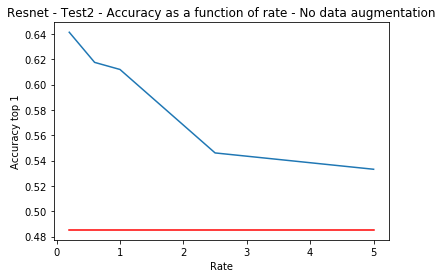

In [8]:
#Running Test2 for CIFAR10 NDA with Resnet
#For a proper test input epochs=100, and loops=10
#The rate used is what is above. But to run the code faster we will use from now on:
rate=np.array([0.2,0.6,1,2.5,5])
epochs=10
loops=1


(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)

model_name= 'Resnet_cifar10_trained_teacher_5000_nda.h5'
accuracy = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher,
                      student, sample_size=5000, epochs=epochs, 
                      data_augmentation=False, lr=0.0001, loops=loops, hard_labels=False)

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
73257
(73257, 10)
(73257,)
0: 4948
1: 13861
2: 10585
3: 8497
4: 7458
5: 6882
6: 5727
7: 5595
8: 5045
9: 4659
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
157/157 [==============================] - 18s 117ms/step - loss: 2.5308 - accuracy: 0.1470 - val_loss: 3.5870 - val_accuracy: 0.0934
Epoch 2/10
157/157 [==============================] - 12s 78ms/step - loss: 1.9744 - accuracy: 0.3504 - val_loss: 2.4163 - val_accuracy: 0.3424
Epoch 3/10


938/938 [==============================] - 29s 31ms/step - loss: 0.8909 - accuracy: 0.8438
Epoch 9/10
938/938 [==============================] - 31s 33ms/step - loss: 0.8857 - accuracy: 0.8440
Epoch 10/10
938/938 [==============================] - 30s 32ms/step - loss: 0.8799 - accuracy: 0.8468
iteration:  0
Test loss: 0.6194073113841225
Test accuracy: 0.860748291015625


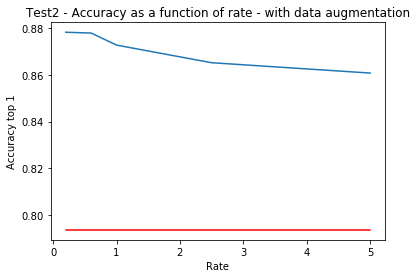

In [11]:
#Running Test2 for HouseNumbers DA with Resnet
#For a proper test input epochs=100, and loops=10

rate=np.array([0.2,0.6,1,2.5,5])
epochs=10
loops=1


(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)

model_name= 'Resnet_HN_trained_teacher_5000_da.h5'
accuracy = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher, student, sample_size=5000, 
                      epochs=epochs,
                      data_augmentation=True, lr=0.0001, loops=loops, hard_labels=False)

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
73257
(73257, 10)
(73257,)
0: 4948
1: 13861
2: 10585
3: 8497
4: 7458
5: 6882
6: 5727
7: 5595
8: 5045
9: 4659
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
157/157 [==============================] - 18s 117ms/step - loss: 2.5562 - accuracy: 0.1260 - val_loss: 2.6170 - val_accuracy: 0.1215
Epoch 2/10
157/157 [==============================] - 12s 77ms/step - loss: 2.2135 - accuracy: 0.2570 - val_loss: 2.0283 - val_accuracy: 0.3373
Epoch 3/10


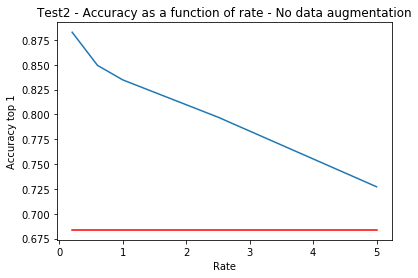

In [15]:
#Running Test2 for HouseNumbers NDA with Resnet
#For a proper test input epochs=100, and loops=10
#Now harcoding epochs=5 for student in stns_full and stns_5000 in order to run faster (it was 10 above)

epochs=10
loops=1


(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
rate=np.array([0.2,0.6,1,2.5,5])
model_name= 'Resnet_HN_trained_teacher_5000_da.h5'
accuracy = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher, student, sample_size=5000, 
                      epochs=epochs,
                      data_augmentation=False, lr=0.0001, loops=loops, hard_labels=False)

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
73257
(73257, 10)
(73257,)
0: 4948
1: 13861
2: 10585
3: 8497
4: 7458
5: 6882
6: 5727
7: 5595
8: 5045
9: 4659
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
157/157 [==============================] - 5s 33ms/step - loss: 2.3043 - accuracy: 0.0920 - val_loss: 2.3014 - val_accuracy: 0.0973
Epoch 2/10
157/157 [==============================] - 5s 31ms/step - loss: 2.3038 - accuracy: 0.0940 - val_loss: 2.3032 - val_accuracy: 0.0670
Epoch 3/10
157/157 [===========================

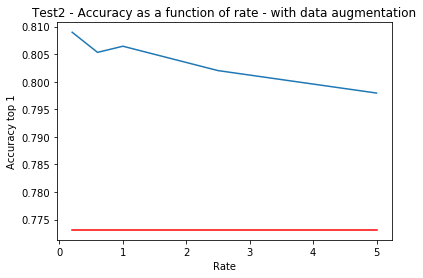

In [16]:
#Running Test2 for HouseNumbers DA with Simple Model (Milestone model)
#For a proper test input epochs=100, and loops=10
epochs=10
loops=1


(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init = choose_simple_teacher_model(input_shape=x_train.shape[1:])
student = choose_simple_student_model(input_shape=x_train.shape[1:])
rate=np.array([0.2,0.6,1,2.5,5])
model_name= 'SM_HN_trained_teacher_5000_da.h5'
accuracy = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher, student, sample_size=5000, 
                      epochs=epochs,
                      data_augmentation=True, lr=0.0001, loops=loops, hard_labels=False)

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
73257
(73257, 10)
(73257,)
0: 4948
1: 13861
2: 10585
3: 8497
4: 7458
5: 6882
6: 5727
7: 5595
8: 5045
9: 4659
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
157/157 [==============================] - 5s 33ms/step - loss: 2.3044 - accuracy: 0.1022 - val_loss: 2.2990 - val_accuracy: 0.1056
Epoch 2/10
157/157 [==============================] - 5s 29ms/step - loss: 1.9744 - accuracy: 0.2884 - val_loss: 1.5444 - val_accuracy: 0.4661
Epoch 3/10
157/157 [===========================

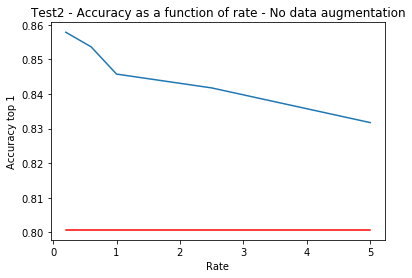

In [17]:
#Running Test2 for HouseNumbers NDA with Simple Model (Milestone model)
#For a proper test input epochs=100, and loops=10
epochs=10
loops=1


(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init = choose_simple_teacher_model(input_shape=x_train.shape[1:])
student = choose_simple_student_model(input_shape=x_train.shape[1:])
rate=np.array([0.2,0.6,1,2.5,5])
model_name= 'SM_HN_trained_teacher_5000_nda.h5'
accuracy = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher, student, sample_size=5000, 
                      epochs=epochs,
                      data_augmentation=False, lr=0.0001, loops=loops, hard_labels=False)

Learning rate:  0.001
50000
(50000, 10)
(50000,)
0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
157/157 [==============================] - 4s 23ms/step - loss: 2.0120 - accuracy: 0.2492 - val_loss: 1.7360 - val_accuracy: 0.3696
Epoch 2/10
157/157 [==============================] - 3s 18ms/step - loss: 1.6923 - accuracy: 0.3864 - val_loss: 1.5955 - val_accuracy: 0.4276
Epoch 3/10
157/157 [==============================] - 3s 19ms/step - loss: 1.5319 - accuracy: 0.4356 - val_loss: 1.4203 - val_accuracy: 0.4783
Epoch 4/10
157/157 [==============================] - 3s 21ms/step - loss: 1.4428 - accuracy: 0.4780 - val_loss: 1.3896 - val_accuracy: 0.4910
Epoch 5/10
157/157 [==============================] - 3s 19ms/step - loss: 1.3837 - accuracy: 0.4982 - val_loss: 1.3261 - val_accuracy: 0.5155
Epo

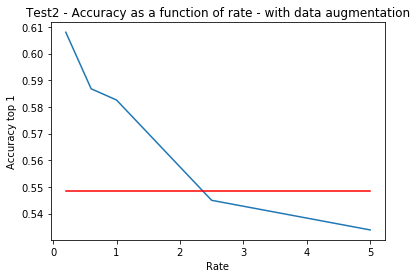

In [18]:
#Running Test2 for CIFAR10 DA with Simple Model (Milestone model)
#For a proper test input epochs=100, and loops=10
epochs=10
loops=1

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init = choose_simple_teacher_model(input_shape=x_train.shape[1:])
student = choose_simple_student_model(input_shape=x_train.shape[1:])
rate=np.array([0.2,0.6,1,2.5,5])
model_name= 'SM_CIFAR_trained_teacher_5000_da.h5'
accuracy = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher, student, sample_size=5000, 
                      epochs=epochs,
                      data_augmentation=True, lr=0.0001, loops=loops, hard_labels=False)

Learning rate:  0.001
50000
(50000, 10)
(50000,)
0: 5000
1: 5000
2: 5000
3: 5000
4: 5000
5: 5000
6: 5000
7: 5000
8: 5000
9: 5000
(5000, 32, 32, 3)
(5000,)
0: 500
1: 500
2: 500
3: 500
4: 500
5: 500
6: 500
7: 500
8: 500
9: 500
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
157/157 [==============================] - 3s 21ms/step - loss: 1.9583 - accuracy: 0.2802 - val_loss: 1.6951 - val_accuracy: 0.3656
Epoch 2/10
157/157 [==============================] - 3s 19ms/step - loss: 1.6521 - accuracy: 0.3896 - val_loss: 1.6450 - val_accuracy: 0.4012
Epoch 3/10
157/157 [==============================] - 3s 21ms/step - loss: 1.5508 - accuracy: 0.4270 - val_loss: 1.4577 - val_accuracy: 0.4618
Epoch 4/10
157/157 [==============================] - 3s 19ms/step - loss: 1.4512 - accuracy: 0.4732 - val_loss: 1.4024 - val_accuracy: 0.4773
Epoch 5/10
157/157 [==============================] - 3s 18ms/step - loss: 1.3804 - accuracy: 0.4978 - val_loss: 1.3982 - val_accuracy: 0.4958
Epo

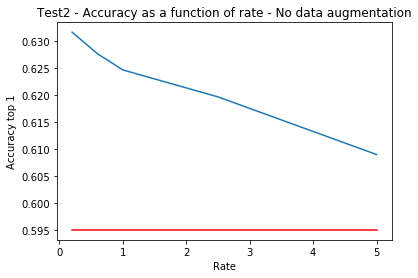

In [19]:
#Running Test2 for CIFAR10 NDA with Simple Model (Milestone model)
#For a proper test input epochs=100, and loops=10
epochs=10
loops=1

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init = choose_simple_teacher_model(input_shape=x_train.shape[1:])
student = choose_simple_student_model(input_shape=x_train.shape[1:])
rate=np.array([0.2,0.6,1,2.5,5])
model_name= 'SM_CIFAR_trained_teacher_5000_nda.h5'
accuracy = stns_5000(init, model_name, x_train,y_train,x_test,y_test,rate,teacher, student, sample_size=5000, 
                      epochs=epochs,
                      data_augmentation=False, lr=0.0001, loops=loops, hard_labels=False)

Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
1563/1563 [==============================] - 58s 37ms/step - loss: 1.5689 - accuracy: 0.4877 - val_loss: 1.3825 - val_accuracy: 0.5703
Epoch 2/10
1563/1563 [==============================] - 51s 33ms/step - loss: 1.1831 - accuracy: 0.6388 - val_loss: 1.5110 - val_accuracy: 0.5522
Epoch 3/10
1563/1563 [==============================] - 52s 33ms/step - loss: 1.0220 - accuracy: 0.6983 - val_loss: 1.3697 - val_accuracy: 0.6012
Epoch 4/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.9239 - accuracy: 0.7356 - val_loss: 1.0505 - val_accuracy: 0.6924
Epoch 5/10
1563/1563 [==============================] - 57s 36ms/step - loss: 0.8627 - accuracy: 0.7582 - val_loss: 1.0215 - val_accuracy: 0.7191
Epoch 6/10
1563/1563 [==============================] - 53s 34ms/step - loss: 0.8112 - accuracy: 0.7797 - val_loss: 1.0603 - val_accuracy: 0.7055
Epoch 7/10
1

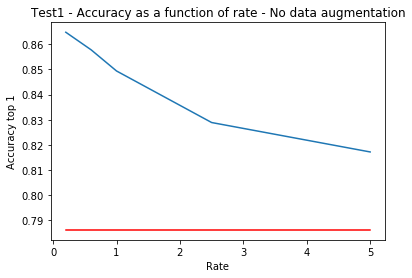

In [20]:
#Test1
#Restnet20 on full CIFAR10 train dataset without data augmentation
#For a proper test input epochs=100, and loops=6
epochs=10
loops=1

(x_train,y_train),(x_test,y_test) = prepare_cifar10_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
accuracy_supervised, teacher_path = train_model(init, teacher, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, 
                                                epochs=epochs, model_name= 'cifar10_test1.h5')

rate=np.array([0.2,0.6,1,2.5,5])
accuracy=stns_full_dataset(x_train,y_train,x_test,y_test,rate,teacher, student,teacher_path,accuracy_supervised, 
                           data_augmentation=False, loops=loops, lr=0.0001, hard_labels=False)

Shape of x_train is: (32, 32, 3, 73257)
Shape of y_train is: (73257, 1)
Shape of x_test is: (32, 32, 3, 26032)
Shape of y_test is: (26032, 1)
Shape of x_train is now: (73257, 32, 32, 3)
Shape of x_test is now: (26032, 32, 32, 3)
Shape of y_train is now: (73257,)
Shape of y_test is now: (26032,)
labels of y_train are [0 1 2 3 4 5 6 7 8 9]
labels of y_test are [0 1 2 3 4 5 6 7 8 9]
Learning rate:  0.001
Learning rate:  0.001
ResNet20v1
Learning rate:  0.001
Using real-time data augmentation.
Epoch 1/10
2290/2290 [==============================] - 89s 39ms/step - loss: 1.0542 - accuracy: 0.7068 - val_loss: 0.7366 - val_accuracy: 0.8237
Epoch 2/10
2290/2290 [==============================] - 82s 36ms/step - loss: 0.5966 - accuracy: 0.8659 - val_loss: 0.5564 - val_accuracy: 0.8775
Epoch 3/10
2290/2290 [==============================] - 82s 36ms/step - loss: 0.5346 - accuracy: 0.8871 - val_loss: 0.4992 - val_accuracy: 0.8966
Epoch 4/10
2290/2290 [==============================] - 84s 37ms/st

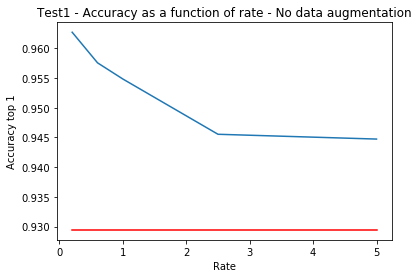

In [21]:
#Test1
#Restnet20 on full House numbers train dataset without data augmentation
#For a proper test input epochs=100, and loops=6
epochs=10
loops=1

(x_train,y_train),(x_test,y_test) = prepare_house_numbers_data(subtract_pixel_mean=True)
teacher, init, model_type = choose_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
student = choose_noised_resnet_model(input_shape=x_train.shape[1:], n=3,version=1)
accuracy_supervised, teacher_path = train_model(init, teacher, x_train, y_train, x_test, y_test, batch_size=32, num_classes=10, 
                                                epochs=epochs, model_name= 'HN_test1.h5')

rate=np.array([0.2,0.6,1,2.5,5])
accuracy=stns_full_dataset(x_train,y_train,x_test,y_test,rate,teacher, student,teacher_path,accuracy_supervised, 
                           data_augmentation=False, loops=loops, lr=0.0001, hard_labels=False)